In [1]:
!pip install mne
!pip install numpy
!pip install matplotlib
!pip install nilearn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [4]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import ttest_ind, ttest_rel

# "Recreating" some of the plots from Rousselet et al (2016) ish
A variety of plots that can be used for inspiration for your own projects.

In [5]:
# picks of channels and timewindow
picks = ["O1", "Oz", "O2"]

# time window in seconds
tmin, tmax = 0.1, 0.2

# load in the data
all_epochs = []

data_path = Path("/work/EEG_lab/example_data")

for participant in ["Group1", "Group5", "Group6"]:
    epochs = mne.read_epochs(data_path / f"{participant}-epo.fif", verbose=False, preload=True)

    # only keep eeg channels
    epochs.pick(["eeg"])

    all_epochs.append(epochs)


print(type(all_epochs)) # we have now created a list of epochs objects
print(len(all_epochs)) # we have 3 epochs objects in the list
print(type(all_epochs[0])) # we can access the first epochs object in the list which is a Epochs object


# PAIRED T-TEST
# create empty arrays to store the data 
word = np.array([])
image = np.array([])

for epochs in all_epochs: # loop over the list with epochs for each participant

    # extract the trials you are interested in
    epochs1 = epochs["Word"]
    epochs2 = epochs["Image"]

    # extract the data for the time window and channels of interest
    data1= epochs1.get_data(picks = picks, tmin = tmin, tmax = tmax)
    data2 = epochs2.get_data(picks = picks, tmin = tmin, tmax = tmax)

    # calculate the mean over the time, channel and trial dimension (axis 0, 1 and 2)
    data1_mean = np.mean(data1, axis=(0, 1, 2))
    data2_mean = np.mean(data2, axis=(0, 1, 2))

    # append the data to the arrays
    word = np.append(word, data1_mean)
    image = np.append(image, data2_mean)

print(word)
print(image)

# now using paired t-test
ttest_rel(word, image)


<class 'list'>
3
<class 'mne.epochs.EpochsFIF'>
[-7.08230864e-06 -4.33707991e-06 -2.76342117e-06]
[-6.65635744e-06 -4.72180027e-06 -5.17024915e-06]


TtestResult(statistic=0.9361547827207205, pvalue=0.4480190442834888, df=2)

Extracting data from the entire time window for each trial for each participant and condition to get you started:

In [6]:
# create empty arrays to store the data 
word_plot = []
image_plot = []

for epochs in all_epochs: # loop over the list with epochs for each participant

    # extract the trials you are interested in
    epochs1 = epochs["Word"]
    epochs2 = epochs["Image"]

    # extract the data for the time window and channels of interest
    data1= epochs1.get_data(picks = picks)
    data2 = epochs2.get_data(picks = picks)

    # append the data to the arrays
    word_plot.append(data1)
    image_plot.append(data2)


# we now have a list of arrays with the data for each participant
print(type(word_plot)) # we have now created a list of arrays
print(len(word_plot)) # we have 3 array objects in the list
print(type(word_plot[0])) # we can access the first array object in the list which is a numpy array
print(word_plot[0].shape) # the shape of the array is (number of trials, number of channels, number of time points)

<class 'list'>
3
<class 'numpy.ndarray'>
(60, 3, 175)


In [7]:
# preparing data for plotting
plotting_data_img = {}
plotting_data_word = {}

participants = ["Group1", "Group5", "Group6"]

for participant, epochs in zip(participants, all_epochs):
    data_img = epochs["Image"].get_data(picks = picks)
    data_word = epochs["Word"].get_data(picks = picks)

    plotting_data_img[participant] = np.mean(data_img, axis=1)
    plotting_data_word[participant] = np.mean(data_word, axis=1)

In [8]:
times = epochs.times

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


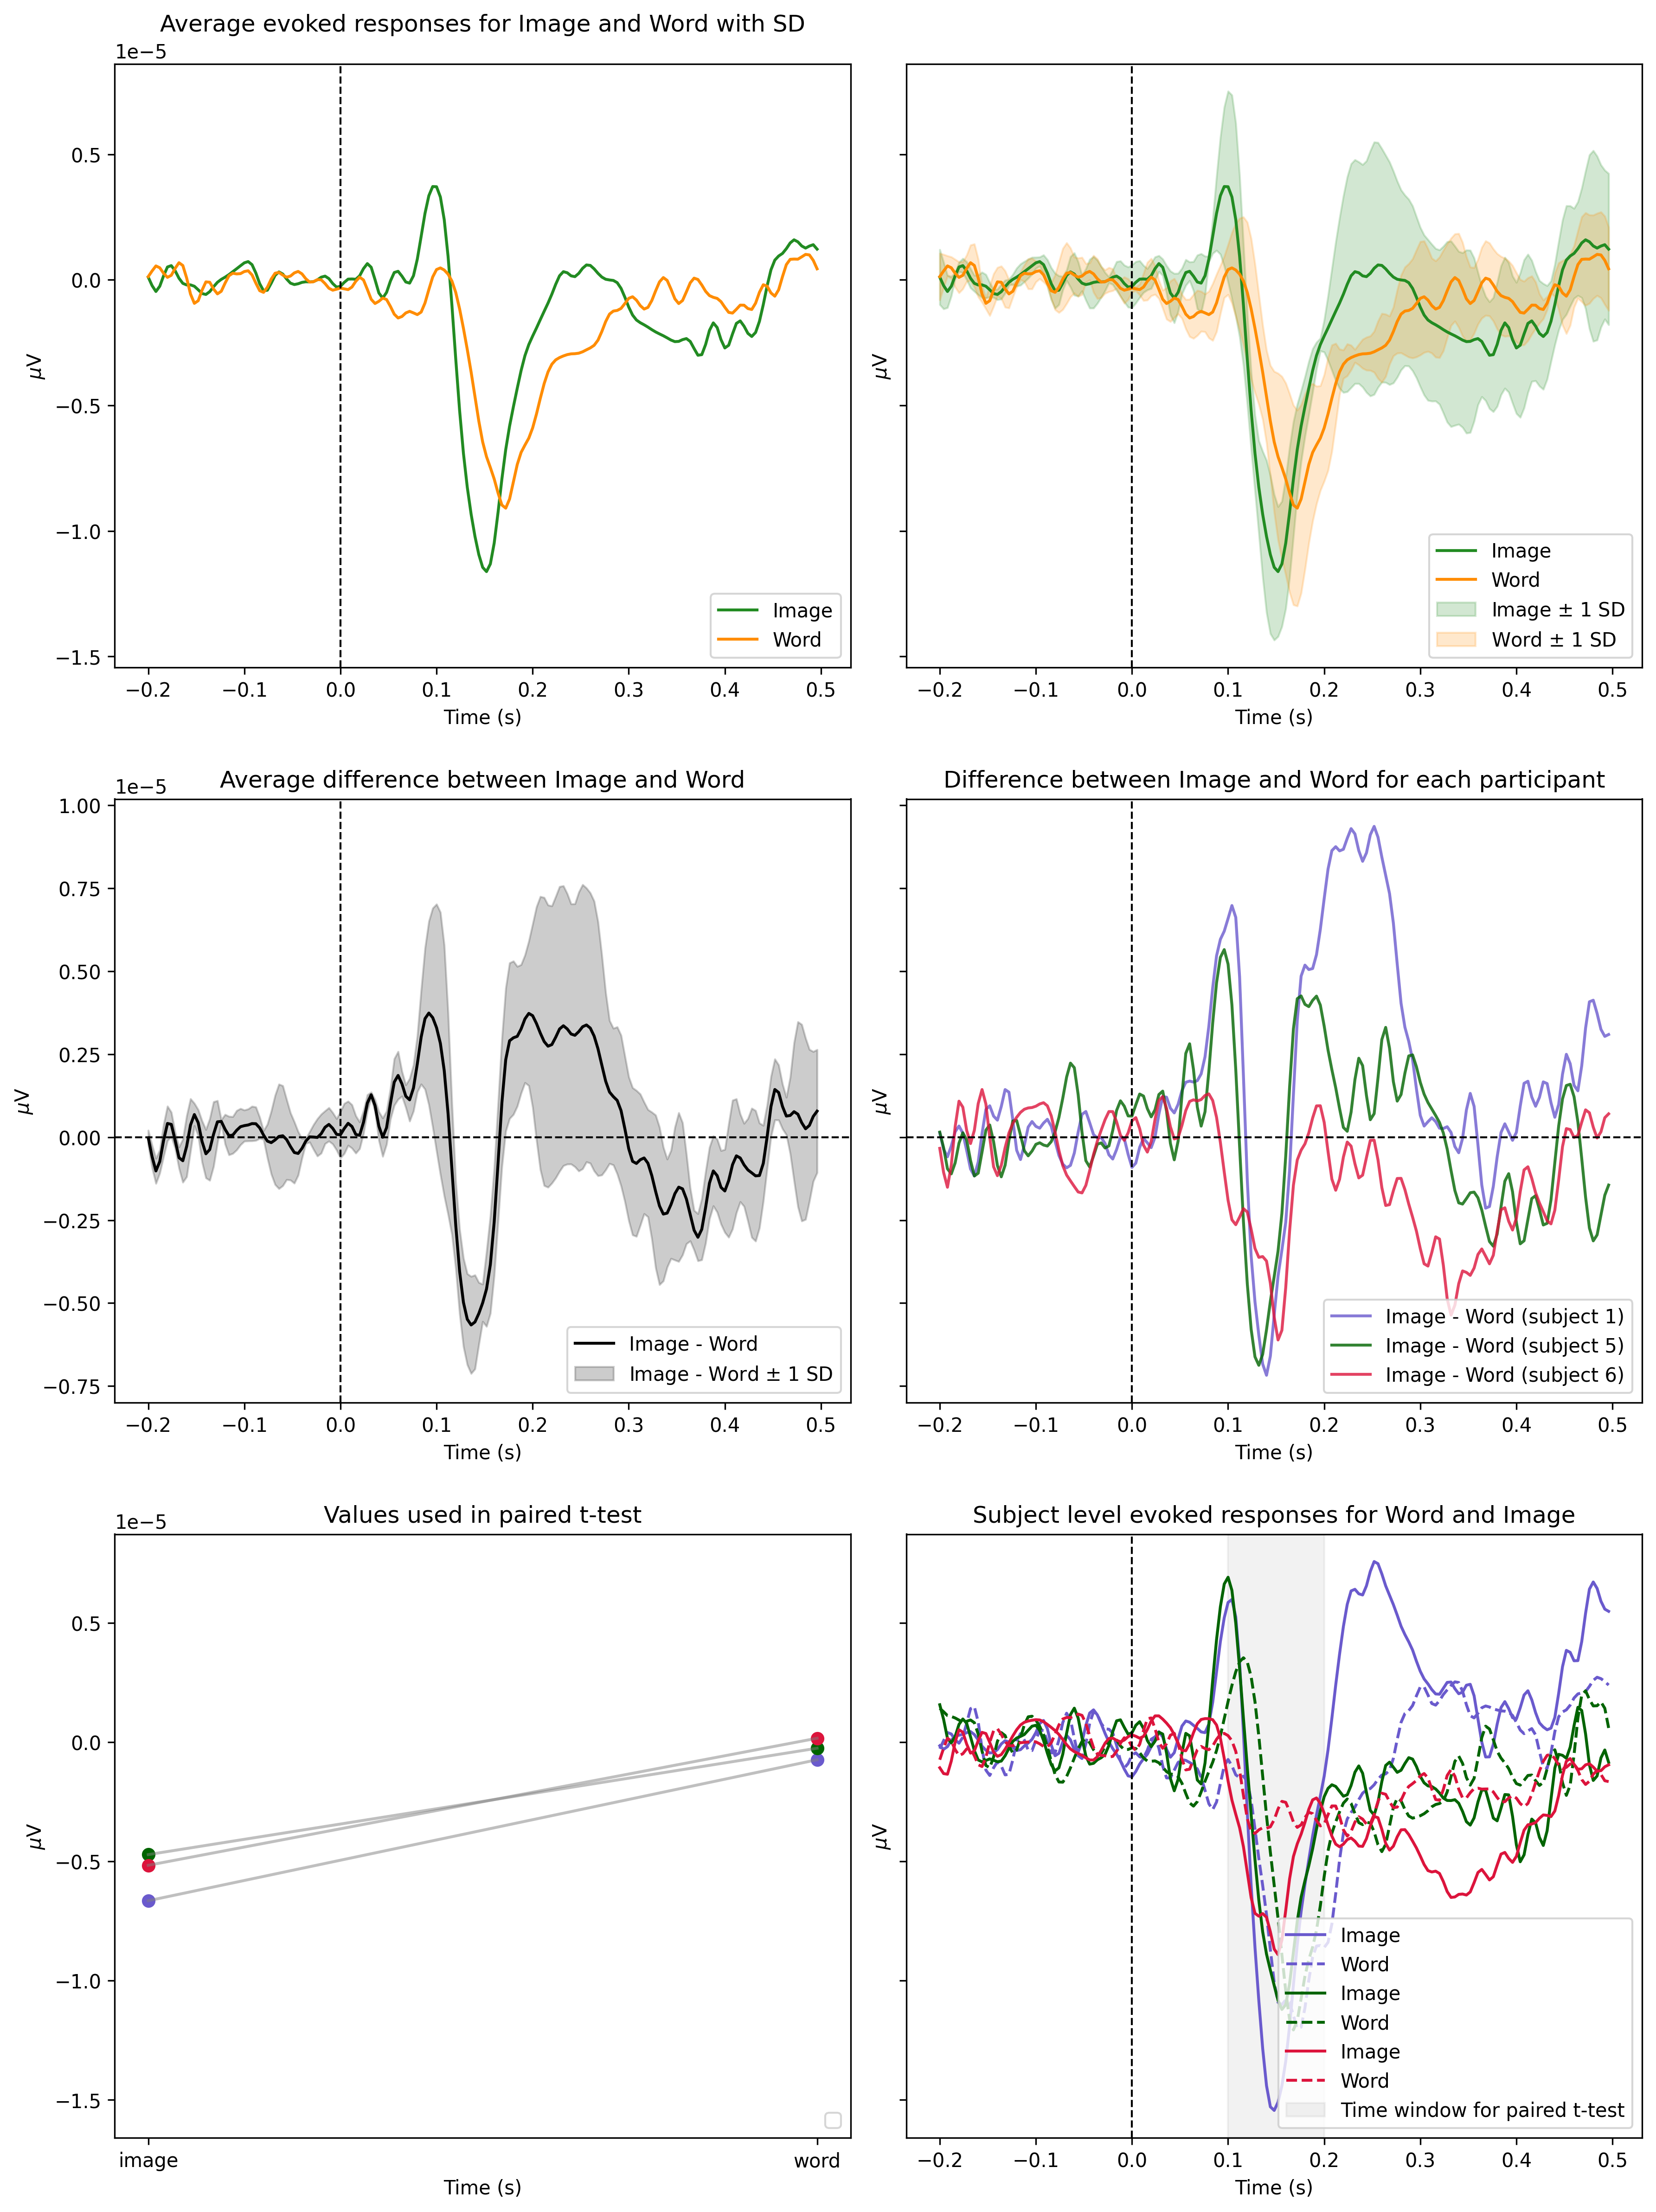

In [10]:
n_rows, n_cols = 3, 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 16), dpi=300, sharey="row")
 
### FIRST PLOT ###
# average over participants
# stack average for each particpant so shape =  (participants, timepoints )
group_lvl_img = np.stack([plotting_data_img[participant].mean(axis = 0) for participant in participants])
group_lvl_word = np.stack([plotting_data_word[participant].mean(axis = 0) for participant in participants])

# average over participants
avg_group_lvl_img = group_lvl_img.mean(axis=0)
avg_group_lvl_word = group_lvl_word.mean(axis=0)

axes[0, 0].plot(times, avg_group_lvl_img, color = "forestgreen", label = "Image")
axes[0, 0].plot(times, avg_group_lvl_word, color = "darkorange", label = "Word")

axes[0, 0].set_title("Average evoked responses for Image and Word")



### SECOND PLOT ###
# including some kind of measure of variance

# standard deviation (maybe not the best measure since we only have 3 participants)
# Note: here i am calculating the standard deviation over the average for each participant
std_group_lvl_img = group_lvl_img.std(axis=0)
std_group_lvl_word = group_lvl_word.std(axis=0)

axes[0, 1].plot(times, avg_group_lvl_img, color = "forestgreen", label = "Image")
axes[0, 1].plot(times, avg_group_lvl_word, color = "darkorange", label = "Word")

axes[0, 1].fill_between(times, avg_group_lvl_img - std_group_lvl_img, avg_group_lvl_img + std_group_lvl_img, color = "forestgreen", alpha = 0.2, label = "Image $\pm$ 1 SD")
axes[0, 1].fill_between(times, avg_group_lvl_word - std_group_lvl_word, avg_group_lvl_word + std_group_lvl_word, color = "darkorange", alpha = 0.2, label = "Word $\pm$ 1 SD")

axes[0, 0].set_title("Average evoked responses for Image and Word with SD")


### THIRD PLOT ###
# plotting the differnence between the conditions (average)

# calculate the difference between the conditions
difference = group_lvl_img - group_lvl_word

# average over participants
avg_diff = difference.mean(axis=0)

# standard deviation
std_diff = difference.std(axis=0)

axes[1, 0].plot(times, avg_diff, color = "black", label = "Image - Word")
axes[1, 0].fill_between(times, avg_diff - std_diff, avg_diff + std_diff, color = "black", alpha = 0.2, label = "Image - Word $\pm$ 1 SD")

# line at no difference
axes[1, 0].axhline(0, color='k', linestyle='--', linewidth=1)

axes[1, 0].set_title("Average difference between Image and Word")


### FOURTH PLOT ###
# difference between the conditions for each participant

colours = ["slateblue", "darkgreen", "crimson"]

for col, diff_subject, participant in zip(colours, difference, participants):
    axes[1, 1].plot(times, diff_subject, color = col, alpha = 0.8, label = f"Image - Word (subject {participant[-1]})")

# line at no difference
axes[1, 1].axhline(0, color='k', linestyle='--', linewidth=1)

axes[1, 1].set_title("Difference between Image and Word for each participant")


### FIFTH PLOT ###
# plotting the values used in the paired t-test (word image)
for i, (w, img) in enumerate(zip(word, image)):
    axes[2, 0].scatter(["image"], img, color = colours[i])
    axes[2, 0].scatter(["word"], w, color = colours[i])

    # draw lines between each pair of observations
    axes[2, 0].plot(["image", "word"], [image[i], word[i],], color = "grey", alpha = 0.5)

axes[2, 0].set_title("Values used in paired t-test")

### SIXTH PLOT ###
# subject level evoked responses for image and word
for i, (img, word) in enumerate(zip(plotting_data_img.values(), plotting_data_word.values())):
    img = img.mean(axis=0)
    word = word.mean(axis=0)
    
    axes[2, 1].plot(times, img, color = colours[i], label = "Image")
    axes[2, 1].plot(times, word, color = colours[i], label = "Word", linestyle = "--")


axes[2, 1].axvspan(tmin, tmax, alpha=0.1, color='grey', label = "Time window for paired t-test")

axes[2, 1].set_title("Subject level evoked responses for Word and Image")


# adding some jazz to all the axes (labels, line at 0)
for i, ax in enumerate(axes.flatten()):
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('$\mu$V')

    ax.legend(loc = "lower right")

    if i != 4:
        ax.axvline(0, color='k', linestyle='--', linewidth=1)

plt.tight_layout()

# Visualisation task 3
Code for loading data and running first and second level models are from the `06_fMRI_analysis` notebook. 

The data contains "10 subjects who were scanned with fMRI during a “language localizer” where they (covertly) read meaningful sentences (trial_type=’language’) or strings of consonants (trial_type=’string’), presented one word at a time at the center of the screen (rapid serial visual presentation)." - [Nilearn documentation](https://nilearn.github.io/dev/modules/description/language_localizer_demo.html)

In [ ]:
from nilearn.datasets import fetch_language_localizer_demo_dataset
from nilearn.glm.first_level import first_level_from_bids

data_dir, _ = fetch_language_localizer_demo_dataset()


task_label = 'languagelocalizer'
models, models_run_imgs, models_events, models_confounds = \
    first_level_from_bids(
        data_dir, task_label,
        img_filters=[('desc', 'preproc')])

In [ ]:
# fitting first level models
model_and_args = zip(models, models_run_imgs, models_events, models_confounds)
zmaps_first_level = []
for m_idx, (model, imgs, events, confounds) in enumerate(model_and_args):
    # fit the GLM, recall that the model variable is a FirstLevelModel object
    model.fit(imgs, events, confounds)
    # compute the contrast of interest and make a map of z-values
    zmap = model.compute_contrast('language-string')
    zmaps_first_level.append(zmap)

In [ ]:
# preparing second level model
from nilearn.glm.second_level import SecondLevelModel
import pandas as pd

# we will simply add the zmaps from the first level as input to the second level model
second_level_input = zmaps_first_level

# create intercept design matrix
design_matrix = pd.DataFrame(
    [1] * len(second_level_input),
    columns=['intercept'],
)


# adding the smoothing parameter and fitting the model 
second_level_model = SecondLevelModel(smoothing_fwhm=8.0)
second_level_model = second_level_model.fit(second_level_input, design_matrix=design_matrix)

# computing the second level contrast
zmap_second_level = second_level_model.compute_contrast()

## Create plot(s)

In [ ]:
# setting a significance threshold
from scipy.stats import norm
p001_unc = norm.isf(0.001)

In [ ]:
**Potential considerations:**

In [ ]:
# you can rely on the nilearn plotting functions to plot the results or another plotting library if you prefer
# have a look in notebooks from lab for inspiration!
import nilearn.plotting as plotting

In [ ]:
# INSERT CODE FOR PLOTTING HERE!